In [25]:
import pandas as pd
import re
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import nltk
import time
import tracemalloc

In [2]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samys\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\samys\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# Load data with utf-8 encoding
with open(r'D:\aip\Findata\train1.json', 'r', encoding='utf-8') as file1, open(r'D:\aip\Findata\train_t.json', 'r', encoding='utf-8') as file2:
    data1 = pd.read_json(file1)
    data2 = pd.read_json(file2)



In [5]:
print(data1.columns)

Index(['table', 'paragraphs', 'questions'], dtype='object')


In [6]:
rows = []
for _, row in data1.iterrows():
    # Access the 'questions' column, which contains the list of question dictionaries
    if isinstance(row['questions'], list):  # Ensure it's a list
        for question in row['questions']:
            x = question['question']  # Extract the question text
            y = 'numerical' if question['answer_type'] == 'arithmetic' else 'contextual'
            rows.append((x, y))

# Create a DataFrame
df1 = pd.DataFrame(rows, columns=['X', 'y'])
print(df1.head())

                                                   X           y
0  What does the Weighted average actuarial assum...  contextual
1            How much is the 2019 rate of inflation?  contextual
2            How much is the 2018 rate of inflation?  contextual
3        What is the 2019 average rate of inflation?   numerical
4  What is the 2019 average rate of increase in s...   numerical


In [7]:
df1.shape

(13215, 2)

In [8]:
# Create DataFrame for train_t.json
rows = []
for _, row in data2.iterrows():
    if 'qa' in row and isinstance(row['qa'], dict):  # Ensure 'qa' column exists and is a dict
        question = row['qa'].get('question', None)  # Extract the 'question'
        if question:  # Only process if the question exists
            rows.append((question, 'numerical'))
df2 = pd.DataFrame(rows, columns=['X', 'y'])

In [9]:
df2.shape

(7462, 2)

In [15]:
df2

,X,y
0,what was the percentage change in the net cash...,numerical
1,what was the percentage change in the net cash...,numerical
2,what was the percentage change in the net cash...,numerical
3,what was the percentage change in the net cash...,numerical
4,what was the percent of the growth in the reve...,numerical
...,...,...
7457,what is the percentage change in gross unpaid ...,numerical
7458,what is the percentage change in gross unpaid ...,numerical
7459,what is the percentage change in gross unpaid ...,numerical
7460,"what was the average capital expenditures , in...",numerical


In [10]:
df = pd.concat([df1, df2], ignore_index=True)

In [11]:
df.shape

(20677, 2)

In [12]:
# Remove duplicate rows
df = df.drop_duplicates()

# Verify the result
print(f"Number of rows after removing duplicates: {len(df)}")
print(df.head())


Number of rows after removing duplicates: 14770
                                                   X           y
0  What does the Weighted average actuarial assum...  contextual
1            How much is the 2019 rate of inflation?  contextual
2            How much is the 2018 rate of inflation?  contextual
3        What is the 2019 average rate of inflation?   numerical
4  What is the 2019 average rate of increase in s...   numerical


In [13]:
# Preprocessing function
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [14]:
#Apply preprocessing
df['X'] = df['X'].apply(preprocess)

# Encode target column
df['y'] = df['y'].map({'numerical': 1, 'contextual': 0})

In [16]:
df['X']

0        what doe the weighted average actuarial assump...
1                   how much is the 2019 rate of inflation
2                   how much is the 2018 rate of inflation
3               what is the 2019 average rate of inflation
4        what is the 2019 average rate of increase in s...
                               ...                        
20659    what percentage of contractual obligation for ...
20663    what is the net change in net revenue during 2008
20667    wha is the percentage change in the valuation ...
20670    what is the percentage change in gross unpaid ...
20675    what wa the average capital expenditure in mil...
Name: X, Length: 14770, dtype: object

In [17]:
df['y']

0        0
1        0
2        0
3        1
4        1
        ..
20659    1
20663    1
20667    1
20670    1
20675    1
Name: y, Length: 14770, dtype: int64

In [18]:
df['y'].value_counts()

y
1    7415
0    7355
Name: count, dtype: int64

In [19]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=20000, min_df=5, max_df=0.7)
X = tfidf.fit_transform(df['X'])

In [20]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, df['y'], test_size=0.2, random_state=42)

In [21]:
# Train models
xgb_model = XGBClassifier()
svm_model = SVC(probability=True)
rf_model = RandomForestClassifier()

xgb_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [22]:
# Evaluate models
models = {
    'XGBoost': xgb_model,
    'SVM': svm_model,
    'Random Forest': rf_model
}


In [26]:
for name, model in models.items():
    print(f"Evaluating {name}...")

    # Measure memory usage
    tracemalloc.start()
    start_time = time.time()

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    auc_score = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'

    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print(f"AUC Score: {auc_score}")
    print(f"Memory Usage: Current = {current / 10**6:.2f} MB, Peak = {peak / 10**6:.2f} MB")
    print(f"Prediction Time: {end_time - start_time:.4f} seconds")
    print("-" * 50)

Evaluating XGBoost...
Model: XGBoost
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1461
           1       0.96      0.95      0.96      1493

    accuracy                           0.96      2954
   macro avg       0.96      0.96      0.96      2954
weighted avg       0.96      0.96      0.96      2954

AUC Score: 0.9902951166589418
Memory Usage: Current = 0.06 MB, Peak = 0.08 MB
Prediction Time: 0.0083 seconds
--------------------------------------------------
Evaluating SVM...
Model: SVM
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1461
           1       0.97      0.95      0.96      1493

    accuracy                           0.96      2954
   macro avg       0.96      0.96      0.96      2954
weighted avg       0.96      0.96      0.96      2954

AUC Score: 0.9877062614354094
Memory Usage: Current = 0.07 MB, Peak = 0.08 MB
Prediction Time: 3.6984 seconds
---------

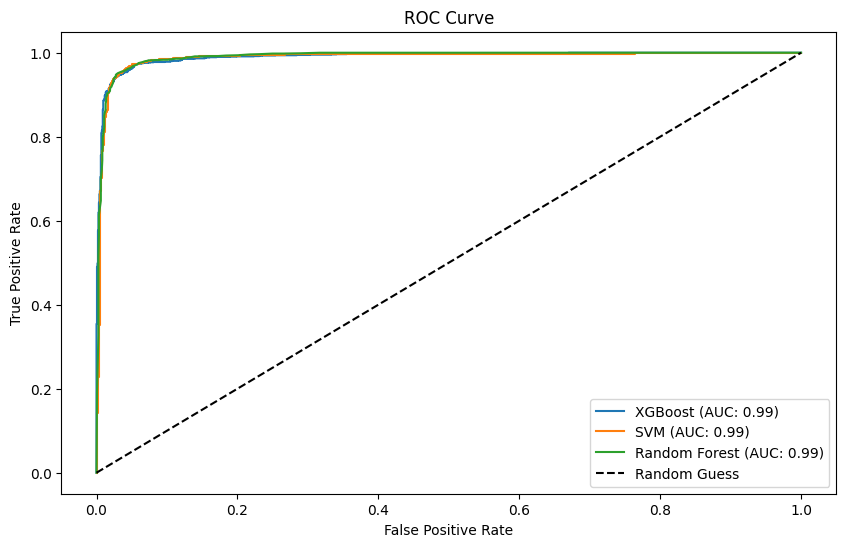

In [24]:
# Visualize AUC scores
plt.figure(figsize=(10, 6))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc_score(y_test, y_prob):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [27]:
def predict_single_input(model, input_text, tfidf_vectorizer):
    """
    Predict the class of a single input and measure the prediction time.

    Args:
        model: Trained machine learning model (e.g., XGBoost, SVM, Random Forest).
        input_text: A single string input for prediction.
        tfidf_vectorizer: The fitted TF-IDF vectorizer used for preprocessing.

    Returns:
        result: Predicted class.
        prediction_time: Time taken for the prediction in seconds.
        memory_usage: Memory used during prediction (current and peak in MB).
    """
    # Preprocess the input text
    preprocessed_text = preprocess(input_text)

    # Transform input text using TF-IDF vectorizer
    input_vectorized = tfidf_vectorizer.transform([preprocessed_text])

    # Measure prediction time and memory usage
    tracemalloc.start()
    start_time = time.time()

    prediction = model.predict(input_vectorized)

    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    prediction_time = end_time - start_time
    memory_usage = (current / 10**6, peak / 10**6)  # Convert bytes to MB

    return prediction[0], prediction_time, memory_usage

In [32]:
input_text = "What were the policies that affected the values"
result, time_taken, memory = predict_single_input(xgb_model, input_text, tfidf)
print(f"Prediction: {result}, Time Taken: {time_taken:.4f} seconds, Memory Usage: Current = {memory[0]:.2f} MB, Peak = {memory[1]:.2f} MB")


Prediction: 0, Time Taken: 0.0024 seconds, Memory Usage: Current = 0.00 MB, Peak = 0.01 MB


In [34]:
import pickle

# Path for saving the XGBoost model
xgboost_model_path = 'xgboost_model.pkl'
vectorizer_path = 'tfidf_vectorizer.pkl'
preprocessor_path = 'preprocessor.pkl'

# Save the XGBoost model
with open(xgboost_model_path, 'wb') as f:
    pickle.dump(xgb_model, f)
    print(f"Saved XGBoost model to {xgboost_model_path}")

# Save TF-IDF vectorizer
with open(vectorizer_path, 'wb') as f:
    pickle.dump(tfidf, f)
    print(f"Saved TF-IDF vectorizer to {vectorizer_path}")

# Save preprocessing function
# Serialize preprocessing function using joblib
preprocessing_code = r'''
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    """Preprocess the input text."""
    text = text.lower()  # Lowercase
    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)
'''

with open(preprocessor_path, 'w') as f:
    f.write(preprocessing_code)
    print(f"Saved preprocessing function to {preprocessor_path}")

print("XGBoost model and required artifacts have been saved.")


Saved XGBoost model to xgboost_model.pkl
Saved TF-IDF vectorizer to tfidf_vectorizer.pkl
Saved preprocessing function to preprocessor.pkl
XGBoost model and required artifacts have been saved.


In [35]:
import pickle
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Paths to saved artifacts
xgboost_model_path = 'xgboost_model.pkl'
vectorizer_path = 'tfidf_vectorizer.pkl'
preprocessor_path = 'preprocessor.pkl'

# Load the XGBoost model
with open(xgboost_model_path, 'rb') as f:
    xgb_model = pickle.load(f)
    print(f"Loaded XGBoost model from {xgboost_model_path}")

# Load the TF-IDF vectorizer
with open(vectorizer_path, 'rb') as f:
    tfidf = pickle.load(f)
    print(f"Loaded TF-IDF vectorizer from {vectorizer_path}")

# Define the preprocessing function
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    """Preprocess the input text."""
    text = text.lower()  # Lowercase
    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

# User input
input_user = "What is the percentage change in revenue?"

# Preprocess the input
preprocessed_input = preprocess(input_user)

# Transform input using TF-IDF vectorizer
input_vectorized = tfidf.transform([preprocessed_input])

# Predict using the XGBoost model
prediction = xgb_model.predict(input_vectorized)

# Map the prediction to output class
output_class = 'numerical' if prediction[0] == 1 else 'contextual'

# Display the result
print(f"Input: {input_user}")
print(f"Prediction: {output_class}")


Loaded XGBoost model from xgboost_model.pkl
Loaded TF-IDF vectorizer from tfidf_vectorizer.pkl
Input: What is the percentage change in revenue?
Prediction: numerical
